# Описание проекта

Модель должна предсказать, кому из клиентов банка можно дать кредит, а кому не стоит. Сначала надо исследовать, какие данные у нас есть, а затем выяснить, какие из них полезны для обучения модели, и не надо ли добавить новых вводных.

Проект выполнен Еленой Виноградовой.

Ссылка на Kaggle: https://www.kaggle.com/lenkavinogradova/project-05-computer-is-say-no-vinogradova
Лучший достигнутый результат: 0.73910
Ник на Kaggle: Lenka Vinogradova (https://www.kaggle.com/lenkavinogradova)


# Описания полей

* client_id - идентификатор клиента

* education - уровень образования
 
* sex - пол заемщика
 
* age - возраст заемщика
 
* car - флаг наличия автомобиля
 
* car_type - флаг автомобиля иномарки
 
* decline_app_cnt - количество отказанных прошлых заявок
 
* good_work - флаг наличия “хорошей” работы
 
* bki_request_cnt - количество запросов в БКИ
 
* home_address - категоризатор домашнего адреса
 
* work_address - категоризатор рабочего адреса
 
* income - доход заемщика
 
* foreign_passport - наличие загранпаспорта
 
* sna - связь заемщика с клиентами банка
 
* first_time - давность наличия информации о заемщике

* score_bki - скоринговый балл по данным из БКИ
 
* region_rating - рейтинг региона
 
* app_date - дата подачи заявки
 
* default - флаг дефолта по кредиту

# Загрузка файлов и библиотек

In [1]:
# необходимые библиотеки
from pandas import Series
import pandas as pd
import numpy as np

import pandas_profiling

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import date
from datetime import datetime, timedelta

from sklearn.preprocessing import PolynomialFeatures

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, recall_score, f1_score, mean_absolute_error, mean_squared_error, precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve

pd.set_option('display.max_rows', 50)  # показывать больше строк
pd.set_option('display.max_columns', 50)  # показывать больше колонок

import warnings
warnings.filterwarnings("ignore")

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sf-dst-scoring/sample_submission.csv
/kaggle/input/sf-dst-scoring/train.csv
/kaggle/input/sf-dst-scoring/test.csv


In [2]:
# функция для построения боксплотов (распределение дефолта в признаках)

def get_boxplot1(column):

    (fig, ax) = plt.subplots(figsize=(14, 4))
    sns.boxplot(x='default', y=column, data=df.loc[df.loc[:, 'default'
                ].isin(df.loc[:, 'default'].value_counts().index[:])],
                ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + 'default')
    plt.show()

In [3]:
PATH_to_file = '/kaggle/input/sf-dst-scoring/'
train = pd.read_csv(PATH_to_file + 'train.csv')
test = pd.read_csv(PATH_to_file + 'test.csv')
sample_submission = pd.read_csv(PATH_to_file + 'sample_submission.csv')

# Предварительное исследование сетов, их объединение и анализ

In [4]:
# Для контроля зафиксируем размер тренировочного и тестового датасетов.
print('Размер тренировочного датасета: ', train.shape,
      'Размер тестового датасета: ', test.shape, 
      'Размер объединенного датасета: ', train.shape[0]+test.shape[0], sep='\n')

Размер тренировочного датасета: 
(73799, 19)
Размер тестового датасета: 
(36349, 18)
Размер объединенного датасета: 
110148


In [5]:
# Объединяем тренировочные и тестовые данные в один датасет.
train['train'] = 1 # помечаем тренировочные
test['train'] = 0 # помечаем тестовые
df = pd.concat([train, test], ignore_index=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

In [6]:
# делаем быстрый EDA с помощью pandas_profiling. Для быстроты действия после первого исследования строка закомментирована. Выводы ниже.
# pandas_profiling.ProfileReport(df)

Выводы:

Все пропуски, которые могут повлиять на модель, сосредоточены в столбце education нашего датасета. Поэтому после анализа мы сразу же переходим к их заполнению.
Женщин в списке больше, чем мужчин, - возможно, это как-то повлияет на дальнейшую аналитику.

Средний возраст заемщика - около 39 лет. Минимальный - 21 год, максимальный - 72, смещение распределения вправо. В этом нет ничего странного (пожилые люди меньше знают о банковских продуктах или более недоверчивы к кредитам), но надо учесть, что распределение нужно поправить (например, логарифмированием) для более хорошей работы модели. Ну и выбросов в этом пункте при таких показателях нет - вот если бы минимальный возраст был 3 года или максимальный - 110, мы бы насторожились. А сейчас все в рамках разумного.

У заемщика скорее нет машины, чем она есть. А если она есть, то это, скорее всего, иномарка.

Чаще всего у заемщика не было отклоненных заявок на кредит, но на графике видно, что есть небольшое количество и других значений. Этот пункт надо особенно тщательно проверить на выбросы - на это указывает максимальное значение: 33. Распределение со смещением вправо.

Скоринговый балл - это числовая оценка кредитоспособности и добросовестности заемщика, прогноз того, как он будет исполнять свои обязательства по обслуживанию и погашению кредита. Средний балл нашей выборки -1.904535049, минимальный -3.62458632, максимальный 0.19977285. Судя по графику, значения распределены нормально.

Внимательно надо посмотреть на признак "рейтинг региона", в нем есть смещение распределения влево. Уточнить, какое количество заемщиков из региона с низким рейтингом и что с ними делать (уж не выбросы ли это?)

График распределения доходов смещен влево, и это естественно: те, кто берет кредит, располагают небольшими собственными средствами. Проверить на выбросы и посмотреть, нельзя ли ограничить эту часть датасета "сверху".

Default - наша целевая переменная. В ней есть пропуски (от тестового сета), но их можно не заполнять, они на модель не повлияют.

# Что делать с пропусками?

In [7]:
# Пропуски в колонке education заполним самым часто встречающимся значением и уточним, не осталось ли пропусков еще где-то.
ed_x = df.education.mode().item()
df.education = df.education.fillna(ed_x)

In [8]:
df.isna().sum()

client_id               0
app_date                0
education               0
sex                     0
age                     0
car                     0
car_type                0
decline_app_cnt         0
good_work               0
score_bki               0
bki_request_cnt         0
region_rating           0
home_address            0
work_address            0
income                  0
sna                     0
first_time              0
foreign_passport        0
default             36349
train                   0
dtype: int64

# Разбираемся с датой

In [9]:
# переводим дату в нужный вид:
df.app_date = pd.to_datetime(df.app_date)

# Выводим период наблюдений:
display(df.app_date.max())
display(df.app_date.min())

Timestamp('2014-04-30 00:00:00')

Timestamp('2014-01-01 00:00:00')

In [10]:
# Можно не выводить год, он везде будет 2014-й
df['app_day'] = df.app_date.dt.day
df['app_month'] = df.app_date.dt.month
df["app_weekday"] = df.app_date.dt.weekday

In [11]:
# Количество дней, прошедших с начала наблюдений:
df['days'] = (df.app_date - df.app_date.min()).dt.days

<AxesSubplot:>

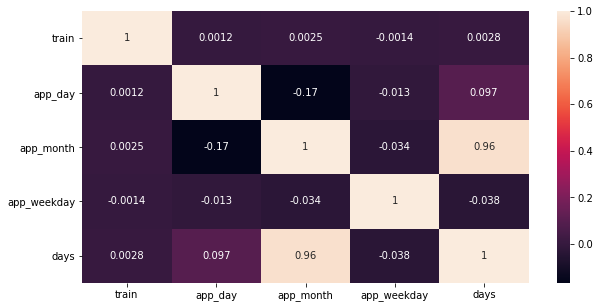

In [12]:
# Посмотрим корреляцию - какие новые признаки мы можем сразу же исключить.
plt.figure(figsize=(10,5))
sns.heatmap(df.iloc[:,19:].corr(), annot=True)

In [13]:
# app_month отлично коррелирует с days, поэтому для нашего исследования он не годится. 
# Исключаем. 
# И заодно уберем столбец app_date, он нам больше не нужен.

df.drop(["app_month"], axis=1, inplace=True)
df.drop(["app_date"], axis=1, inplace=True)

# Списки

Начинаем изучать получившиеся признаки. Есть все типы: числовые, бинарные и категориальные. Разобьем их на списки в соответствии с типом.

In [14]:
# числовые
num_cols = [
    'age',
    'decline_app_cnt',
    'score_bki',
    'bki_request_cnt',
    'income',
    'app_day',
    'days',
    ]

# бинарные
bin_cols = ["sex", "car", "car_type", "good_work", "foreign_passport"]

# категориальные
cat_cols = [
    'education',
    'region_rating',
    'home_address',
    'work_address',
    'sna',
    'first_time',
    'app_weekday',
    ]

# Исследуем числовые переменные

<AxesSubplot:>

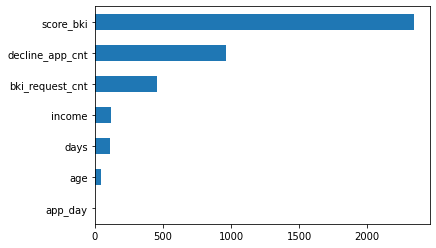

In [15]:
# Проверим значимость числовых переменных:

temp_df = df[df['train'] == 1]
imp_num = Series(f_classif(temp_df[num_cols], temp_df['default'])[0],
                 index=num_cols)
imp_num.sort_values(inplace=True)
imp_num.plot(kind='barh')

Построим боксплоты и определим признаки, которые имеют выбросы, а также те признаки, которые не сильно изменяются для дефолтных и недефолтных клиентов.

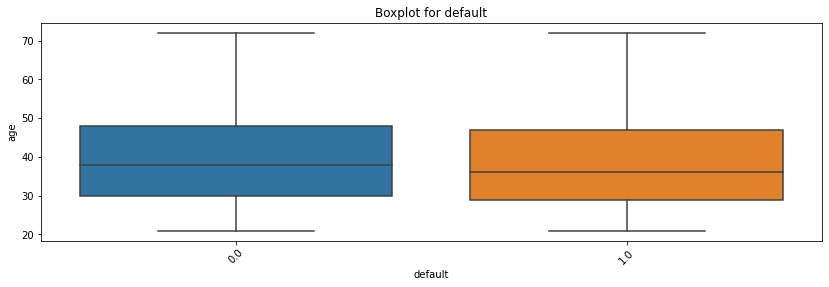

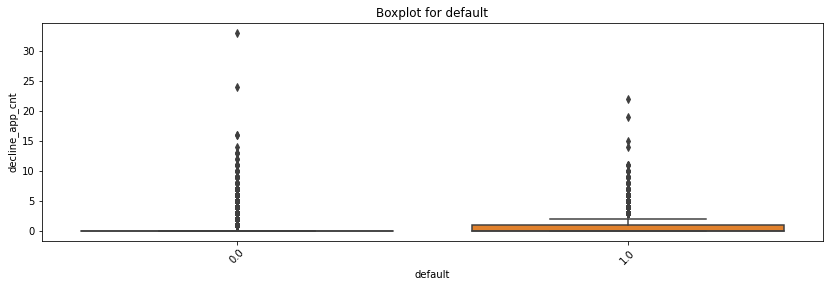

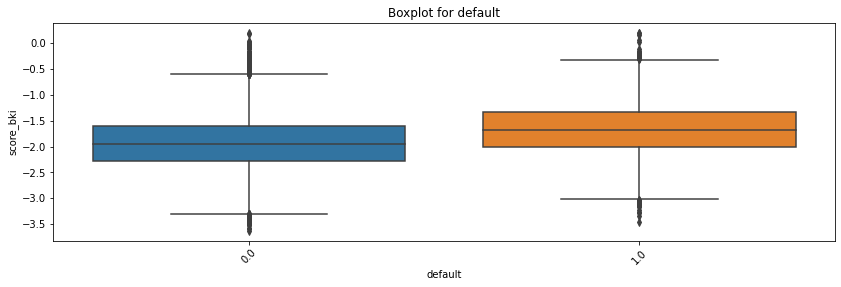

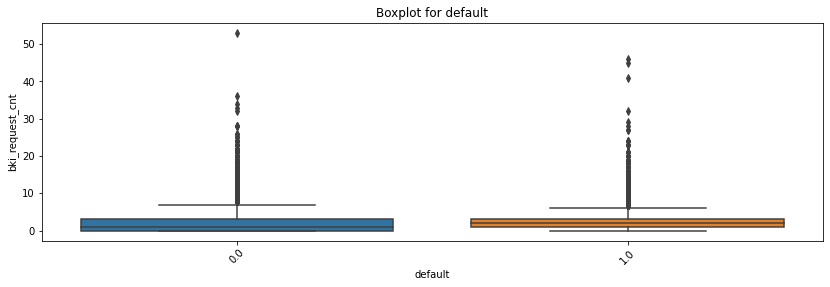

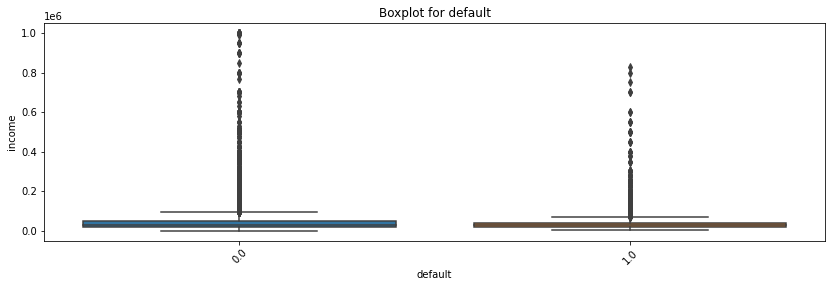

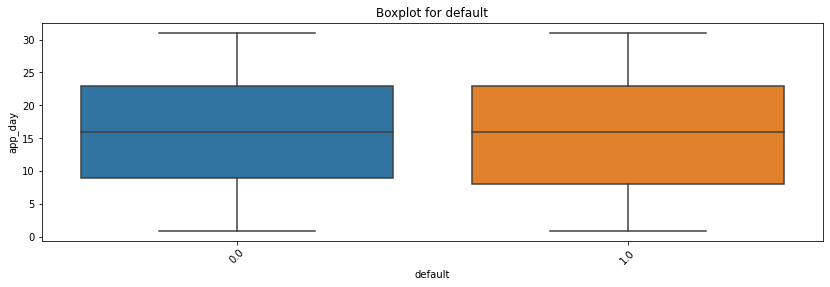

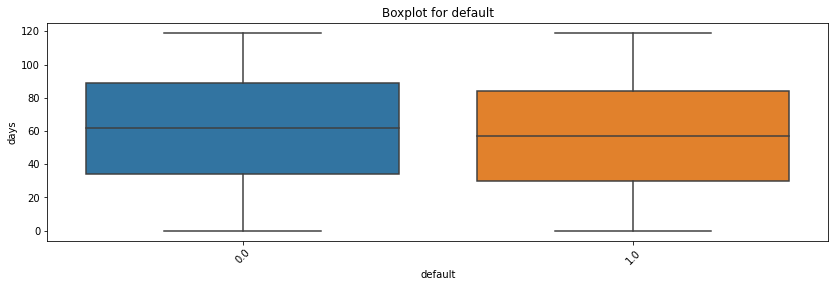

In [16]:
for column in num_cols:
    get_boxplot1(column)

Дефолт практически не зависит от дня месяца и в списке значимости день месяца не важен. Можно этот признак исключить.

In [17]:
df.drop(['app_day'], axis=1, inplace=True)
num_cols.remove('app_day')

In [18]:
# Для уменьшения количества выбросов переведем в категориальный признак количество отказанных прошлых заявок по принципу "одна-две-три-много"

df.decline_app_cnt = df.decline_app_cnt.apply(lambda x: (x if x < 4 else 4))
df.bki_request_cnt = df.bki_request_cnt.apply(lambda x: 7 if x >= 7 else x)

In [19]:
# Перенесем нужную колонку из списка числовых в список категориальных:

num_cols.remove('decline_app_cnt')
cat_cols.append('decline_app_cnt')

num_cols.remove('bki_request_cnt')
cat_cols.append('bki_request_cnt')

Еще про выбросы: в возрасте, как мы уже заметили, их нет. При EDA было обнаружено, что минимальный возраст 21 год, а максимальный - 72, все в порядке. Ни малолетних заемщиков, ни уникальных долгожителей нет.

Но мы можем перенести возраст в категориальную переменную, разделив по процентилям.

In [20]:
df.age.describe()

count    110148.000000
mean         39.249410
std          11.518063
min          21.000000
25%          30.000000
50%          37.000000
75%          48.000000
max          72.000000
Name: age, dtype: float64

In [21]:
perc25 = df.age.quantile(0.25)
perc50 = df.age.quantile(0.5)
perc75 = df.age.quantile(0.75)

In [22]:
def age_to_cat(age):
    if age <= perc25:
        cat_age = '0'
        return cat_age             
    if perc25 < age <= perc50:
        cat_age = '1'
        return cat_age
    if perc50 < age <= perc75:
        cat_age = '2'
        return cat_age
    if age > perc75:
        cat_age = '3'
        return cat_age

In [23]:
df['age_cat'] = 0 # create age_categorical column
df['age_cat'] = df['age'].apply(lambda x:age_to_cat(x))
df = df.drop('age',axis=1)

In [24]:
num_cols.remove('age')
cat_cols.append('age_cat')

<AxesSubplot:>

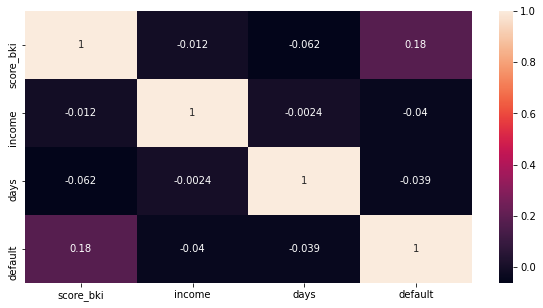

In [25]:
# Построим матрицу корреляций для числовых признаков:
plt.figure(figsize=(10, 5))
sns.heatmap(df[num_cols + ['default']].corr(), annot=True)

Признаки слабо коррелируют, можно оставить все.

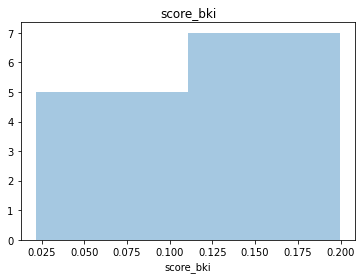

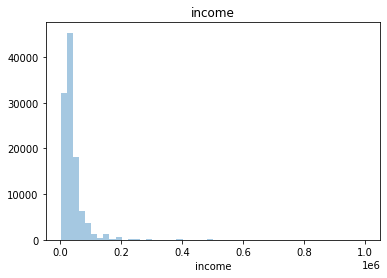

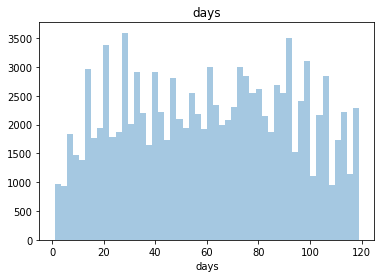

In [26]:
# Поглядим на распределение числовых признаков:
for i in num_cols:
    plt.figure()
    sns.distplot(df[i][df[i] > 0].dropna(), kde=False, rug=False)
    plt.title(i)
    plt.show()

 Признаки можно прологарифмировать, чтобы добиться более нормального распределения. Поскольку в этом пункте у нас остается только доход, выбросы особого значения не имеют (отрицательного дохода ни у кого не было).

In [27]:
# После длительных проверок и экспериментов выяснилось, что лучше всего работает модель, где логарифмирован только доход. Так и оставляем.
num_cols_log = ['income']
for column in num_cols_log:
    df[column] = np.log(df[column] + 5)

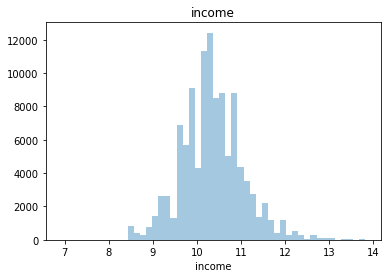

In [28]:
# Поглядим на распределение числовых признаков после логарифмирования.
for i in num_cols_log:
    plt.figure()
    sns.distplot(df[i][df[i] > 0].dropna(), kde = False, rug=False)
    plt.title(i)
    plt.show()

In [29]:
# Добавим новые полиномиальные признаки, которые являются математическими комбинациями числовых признаков.
pf = PolynomialFeatures(2, include_bias=False)
poly_data = pf.fit_transform(df[num_cols])[:, len(num_cols):]
poly_cols = pf.get_feature_names()[len(num_cols):]
poly_df = pd.DataFrame(poly_data, columns=poly_cols)
df = df.join(poly_df, how='left')

In [30]:
# Полиномиальные лучше не обрабатывать вместе с числовыми, от этого модель лучше обучается.
# num_cols = num_cols + poly_cols

# Бинарные переменные

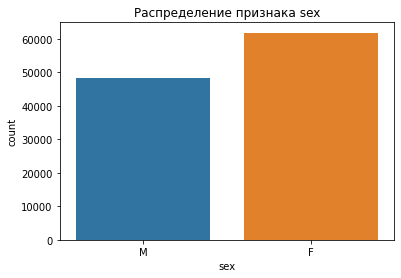

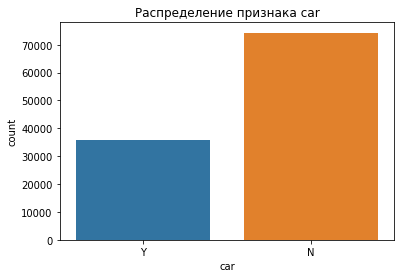

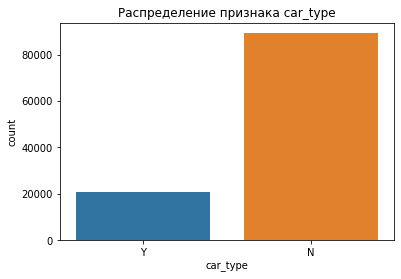

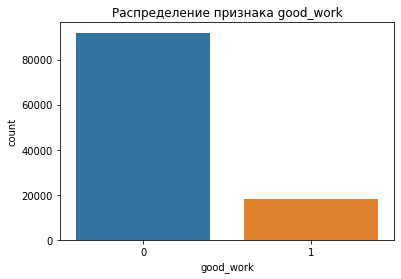

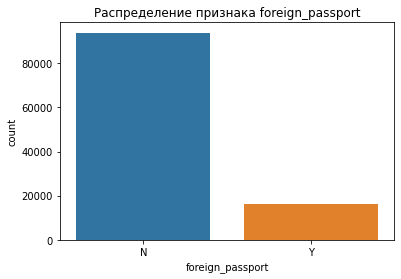

In [31]:
# Построим графики распределения значений по их количеству:
for col in bin_cols:
    plt.figure(figsize=(6, 4))
    sns.countplot(df[col])
    plt.title(f"Распределение признака {col}")

Чаще берут кредит женщины, чем мужчины, люди без хорошей работы (это понятно), люди без загранпаспорта и люди без машины (хотя казалось бы, с машиной самое то кредиты на обслуживание брать...). 

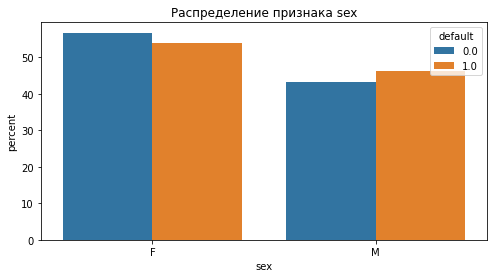

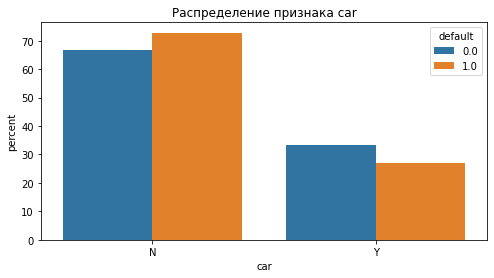

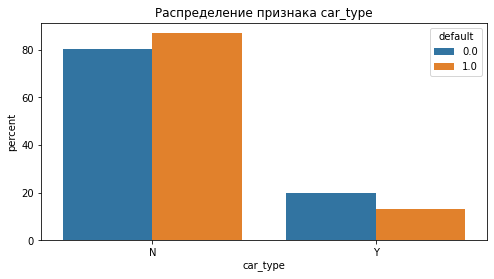

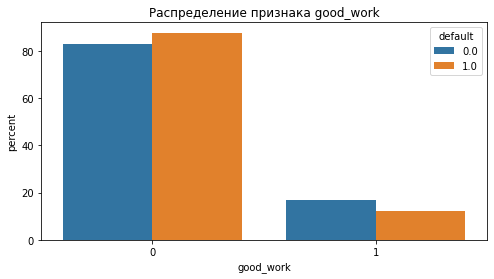

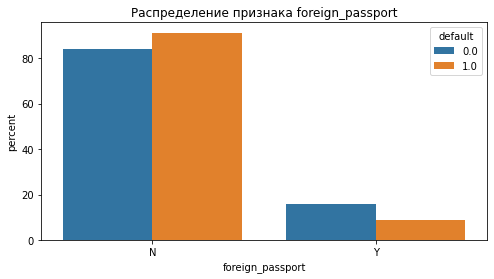

In [32]:
# Построим графики распределения значений по их соотношению с default:
for col in bin_cols:
    plt.figure(figsize=(8, 4))
    prop_df = df[col].groupby(df["default"]).value_counts(
        normalize=True).rename("percent").reset_index()
    prop_df["percent"] *= 100
    sns.barplot(x=col, y="percent", hue="default", data=prop_df)
    plt.title(f"Распределение признака {col}")

Дефолт чаще встречается у женщин, у людей без машины, у людей с плохой работой и без загранпаспорта.

In [33]:
# Для бинарных признаков мы будем использовать LabelEncoder.
label_encoder = LabelEncoder()

for column in bin_cols:
    df[column] = label_encoder.fit_transform(df[column])   

<AxesSubplot:>

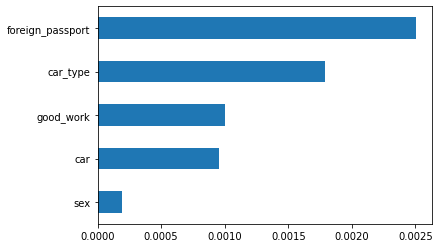

In [34]:
# Проверим значимость бинарных переменных:
temp_df = df[df['train'] == 1]
imp_cat = Series(mutual_info_classif(temp_df[bin_cols],
                 temp_df['default'], discrete_features=True),
                 index=bin_cols)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh')

Все значимые, все оставляем.

<AxesSubplot:>

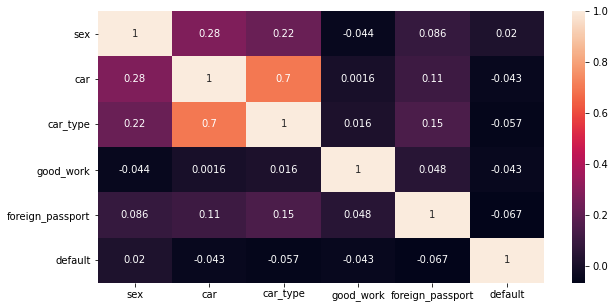

In [35]:
# Построим матрицу корреляций для бинарных признаков:
plt.figure(figsize=(10,5))
sns.heatmap(df[bin_cols+['default']].corr(), annot=True)

Сильно коррелируют car и car_type. Попробуем удалить car как менее значимый, и посмотрим, что изменилось в модели (стало лучше).


In [36]:
df.drop(['car'], axis=1, inplace=True)
bin_cols.remove('car')

# Категориальные переменные

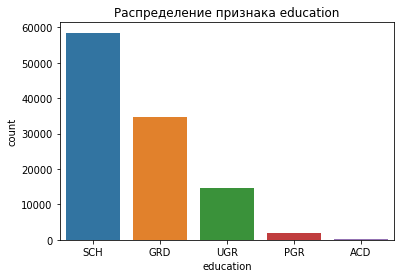

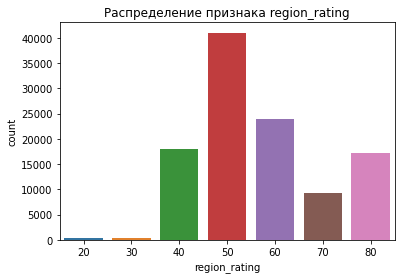

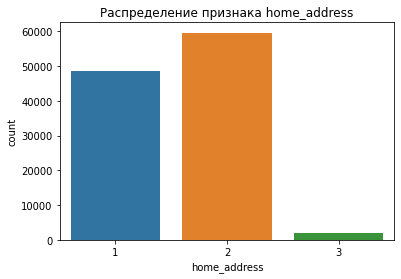

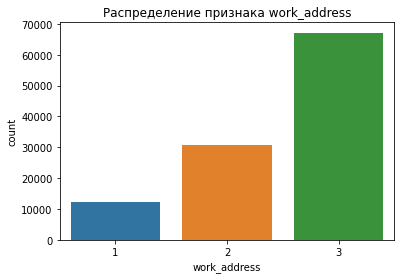

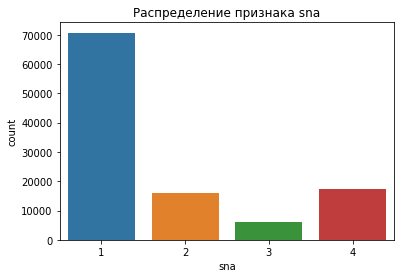

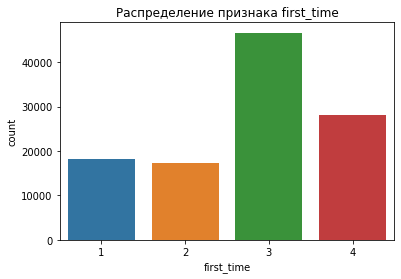

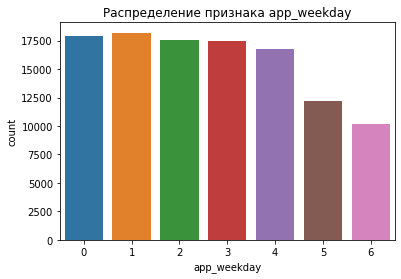

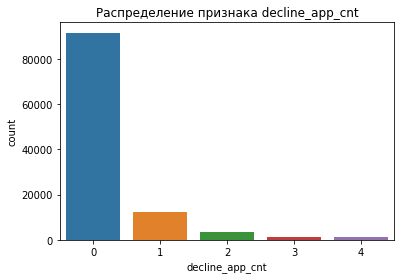

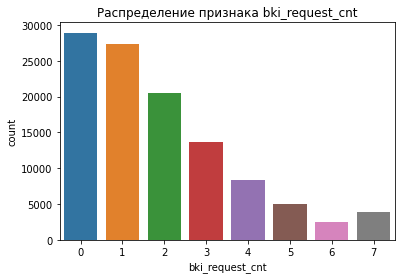

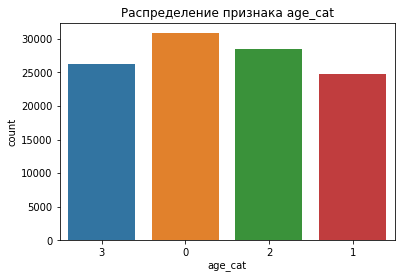

In [37]:
# Построим графики распределения значений по их количеству:
for col in cat_cols:
    plt.figure(figsize=(6, 4))
    sns.countplot(df[col])
    plt.title(f"Распределение признака {col}")

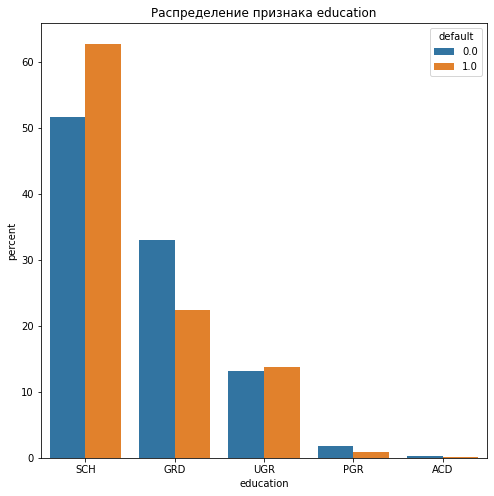

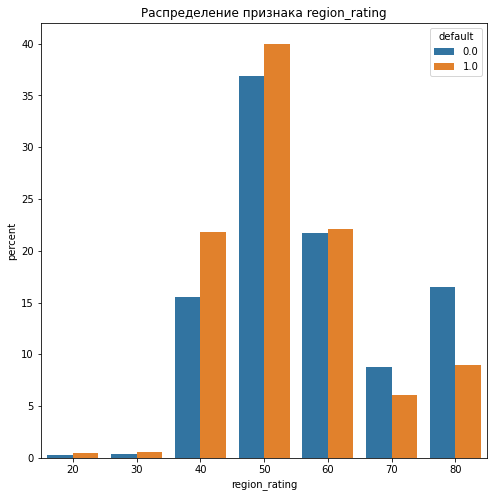

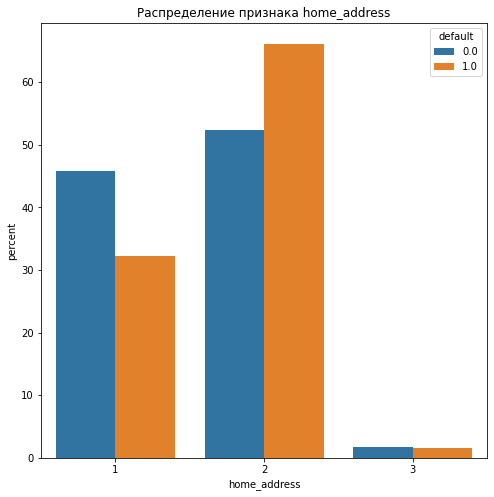

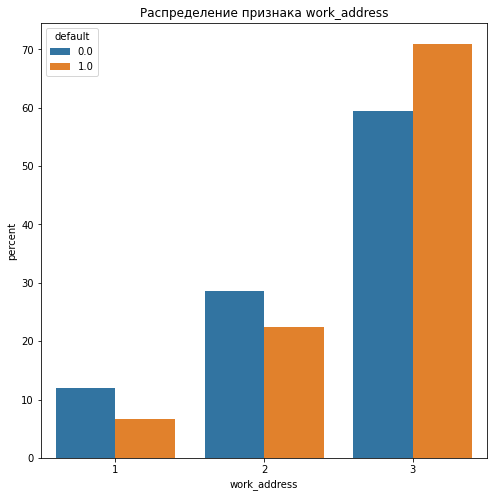

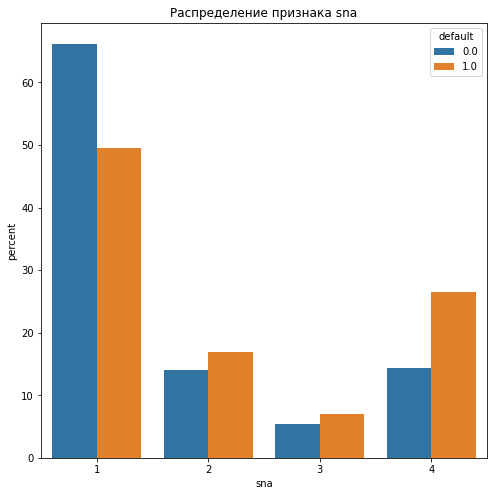

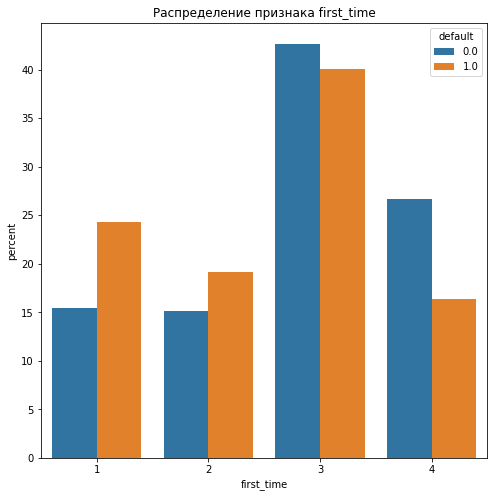

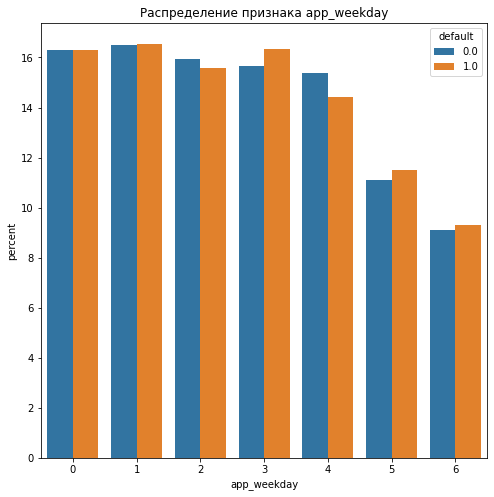

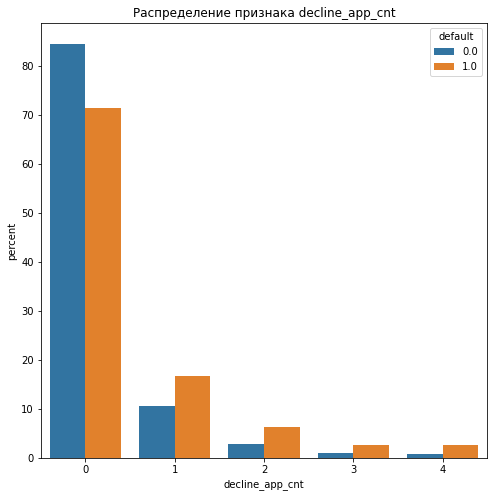

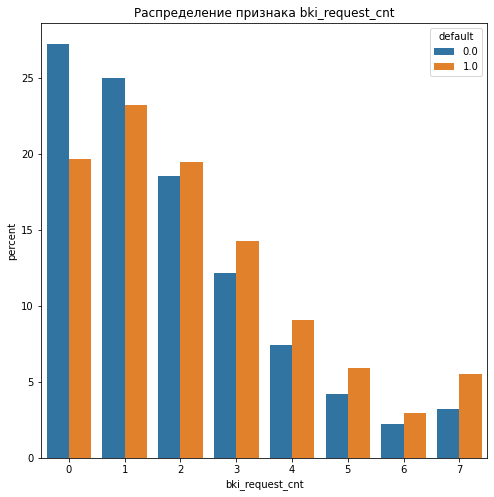

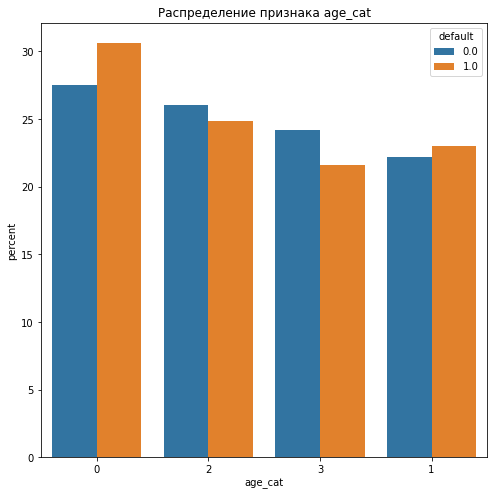

In [38]:
# Построим графики распределения значений по их соотношению с default:
for col in cat_cols:
    plt.figure(figsize=(8,8))
    prop_df = df[col].groupby(df["default"]).value_counts(
        normalize=True).rename("percent").reset_index()
    prop_df["percent"] *= 100
    sns.barplot(x=col, y="percent", hue="default", data=prop_df)
    plt.title(f"Распределение признака {col}")

Интересное наблюдение: люди, которые берут кредит в четверг, чуть чаще не способны выплатить кредит в срок, а люди, которые берут его в пятницу, - наоборот.

И еще наблюдение: чаще всего не платят в срок молодежь и совсем пожилые люди.



In [39]:
# Преобразуем данные признака education в числа:
df['education'] = label_encoder.fit_transform(df['education'])
print(dict(enumerate(label_encoder.classes_)))
df.sample(3)

{0: 'ACD', 1: 'GRD', 2: 'PGR', 3: 'SCH', 4: 'UGR'}


,client_id,education,sex,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,train,app_weekday,days,age_cat,x0^2,x0 x1,x0 x2,x1^2,x1 x2,x2^2
58949,19799,1,0,0,0,0,-1.961228,7,50,1,2,9.341807,1,3,0,0.0,1,0,26,3,3.846416,-18.321416,-50.991935,87.269361,242.886986,676.0
14953,25559,1,0,0,0,0,-1.988832,7,40,1,2,10.714529,1,3,1,0.0,1,5,31,2,3.955454,-21.309403,-61.653806,114.801129,332.150395,961.0
9090,89635,1,0,0,1,0,-2.071482,2,60,2,3,10.309119,1,4,0,0.0,1,6,95,1,4.291037,-21.355153,-196.790771,106.277941,979.366335,9025.0


<AxesSubplot:>

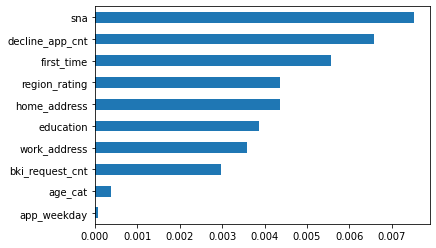

In [40]:
# Проверим значимость категориальных переменных:
temp_df = df[df['train'] == 1]
imp_cat = Series(mutual_info_classif(temp_df[cat_cols],
                 temp_df['default'], discrete_features=True),
                 index=cat_cols)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh')

Мы видим, что самый значимый признак среди категориальных - есть ли у заемщика связи с клиентами банка. Самый незначительный, но все-таки влияющий на модель, - день недели, когда подана заявка. Оставляем все.

<AxesSubplot:>

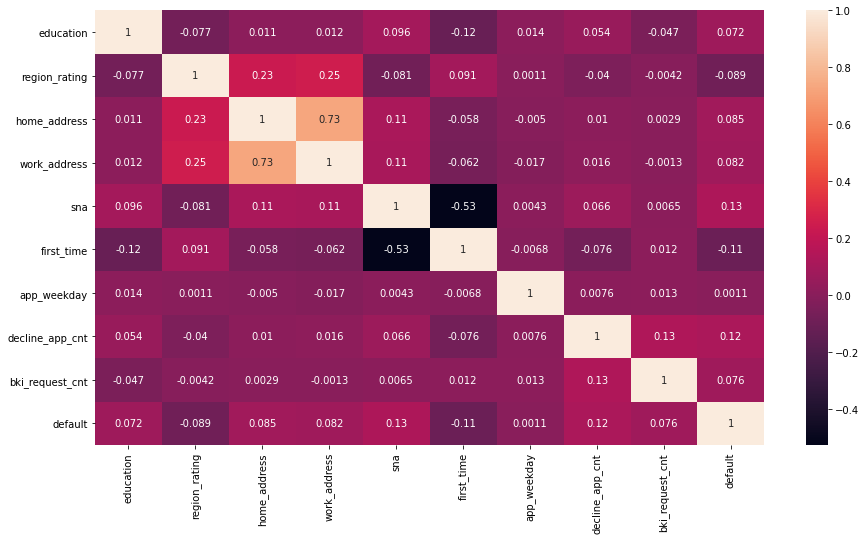

In [41]:
# Построим матрицу корреляций для категориальных признаков:
plt.figure(figsize=(15,8))
sns.heatmap(df[cat_cols+['default']].corr(), annot=True)

Рабочий адрес менее значим. Попробуем его... того! А, нет, без него хуже.

In [42]:
# df.drop(['work_address'], axis=1, inplace=True)
# cat_cols.remove('work_address')

Попробуем объединить рабочий и домашний адреса методом декомпозиции.

In [43]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Выберем из датасета нужные колонки:
data = df[['work_address', 'home_address']].values

# Создадим Scaler instance:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

# Из двух столбцов сделаем один путем усечения ненужной информации.
pca = PCA(n_components=1)
pca.fit(scaled_data)
pca_data = pca.transform(scaled_data)
df['address'] = pca_data

# Уберем ненужные колонки:
df = df.drop(['home_address','work_address'],axis=1)

# Приведем в порядок списки:
cat_cols.remove('home_address')
cat_cols.remove('work_address')
cat_cols.append('address')

# Приступаем к построению модели. Подготовка данных

In [44]:
# Делим датасет обратно - на тест и трейн.
train = df.query('train == 1').drop(['train'], axis=1)
test = df.query('train == 0').drop(['train'], axis=1)

In [45]:
# Проверим на соответствие значений:
print('Размер тренировочного датасета: ', train.shape,
      'Размер тестового датасета: ', test.shape, sep='\n')
# Количество строк соответствует исходным.

Размер тренировочного датасета: 
(73799, 24)
Размер тестового датасета: 
(36349, 24)


In [46]:
# Выводим категориальные переменные в 0 или 1.
X_cat = \
    OneHotEncoder(sparse=False).fit_transform(train[cat_cols].values)

In [47]:
# Стандартизация числовых переменных:
X_num = StandardScaler().fit_transform(train[num_cols].values)

In [48]:
# Объединим стандартизованные числовые, полиномиальные, бинарные и закодированные категориальные переменные в одно 
# признаковое пространство,разделив при этом признаки и целевую переменную.
X = np.hstack([X_num, train[bin_cols].values, train[poly_cols].values, X_cat])
Y = train['default'].values
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

# Первая попытка обучения модели

In [49]:
model_1 = LogisticRegression(solver = 'liblinear', max_iter = 1000)
model_1.fit(X_train, y_train)
y_pred = model_1.predict(X_test)
# y_proba = model_1.predict_proba(X_test)[:,1]

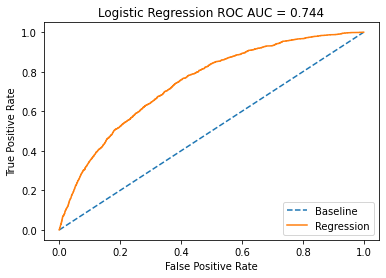

In [50]:
# model = LogisticRegression(max_iter=1000)
# model.fit(X_train, y_train)

probs = model_1.predict_proba(X_test)
probs = probs[:,1]


fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

In [51]:
# Оценка качества:
print('accuracy_score: {}'.format(np.round(accuracy_score(y_test, y_pred), 4)))
print('f1_score: {}'.format(np.round(f1_score(y_test, y_pred), 4)))
print('recall_score: {}'.format(np.round(recall_score(y_test, y_pred), 4)))
print('MSE: {}'.format(np.round(mean_squared_error(y_test, y_pred), 4)))

accuracy_score: 0.8755
f1_score: 0.0306
recall_score: 0.0159
MSE: 0.1245


In [52]:
confusion_matrix(y_test, y_pred)

array([[12894,    39],
       [ 1798,    29]])

<AxesSubplot:>

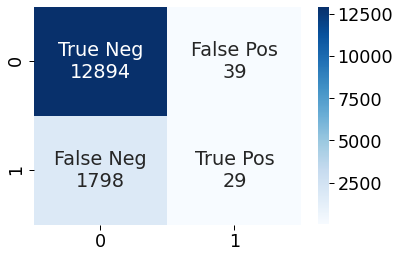

In [53]:
# Визуализация confusion matrix:
sns.set_context(context='paper', font_scale=2, rc=None)
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                confusion_matrix(y_test, y_pred).flatten()]
labels = [f'{v1}\n{v2}' for v1, v2 in
          zip(group_names, group_counts)]
labels = np.asarray(labels).reshape(2, 2)
sns.heatmap(confusion_matrix(y_test, y_pred), annot=labels, fmt='', cmap='Blues')

Матрица шикарно предсказывает людей, которые обойдутся без дефолта. Но наша-то задача найти и тех, кто дефолт получит, иначе прощайте, деньги банка...
Подумаем еще раз.


# Вторая попытка. Oversampling

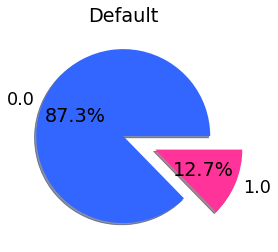

In [54]:
# Посмотрим на распределение целевого признака 'default':

default_data = df['default'].value_counts()
default_labels = list(df['default'].value_counts().index)
colors = ['#3366FF', '#FF3399']
plt.pie(
    default_data,
    labels=default_labels,
    autopct='%1.1f%%',
    shadow=True,
    colors=colors,
    explode=[0, 0.4],
    )
plt.title('Default')
plt.show()

Клиентов без дефолта в банке значительно больше. Есть у нас тут переобучение, надо с ним бороться.

In [55]:
# Попробуем применить oversampling, чтобы сгладить разницу.
zeros = train[train['default'] == 0]
ones = train[train['default'] == 1]
default_new = int(len(zeros) / len(ones))
for i in range(default_new):
    train1 = train.append(ones).reset_index(drop=True)

In [56]:
X_cat = OneHotEncoder(sparse = False).fit_transform(train1[cat_cols].values)
X_num = StandardScaler().fit_transform(train1[num_cols].values)
X = np.hstack([X_num, train1[bin_cols].values, train1[poly_cols].values, X_cat])
Y = train1['default'].values

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

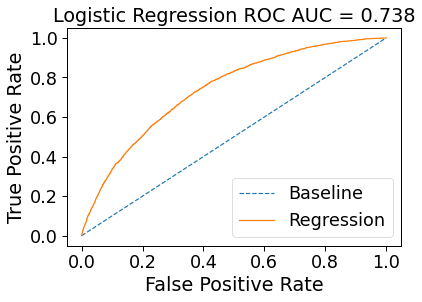

In [58]:
model_2 = LogisticRegression(solver = 'liblinear', max_iter = 2000)
model_2.fit(X_train, y_train)
probs = model_2.predict_proba(X_test)
probs = probs[:,1]


fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

In [59]:
y_pred = model_2.predict(X_test)

In [60]:
# Оценка качества:
print('accuracy_score: {}'.format(np.round(accuracy_score(y_test, y_pred), 4)))
print('f1_score: {}'.format(np.round(f1_score(y_test, y_pred), 4)))
print('recall_score: {}'.format(np.round(recall_score(y_test, y_pred), 4)))
print('MSE: {}'.format(np.round(mean_squared_error(y_test, y_pred), 4)))

accuracy_score: 0.7789
f1_score: 0.1798
recall_score: 0.1067
MSE: 0.2211


In [61]:
confusion_matrix(y_test, y_pred)

array([[12554,   304],
       [ 3374,   403]])

<AxesSubplot:>

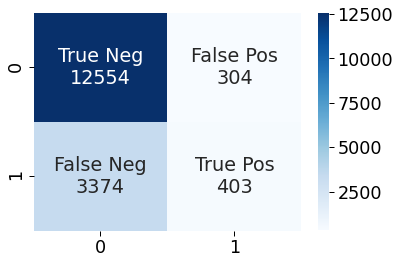

In [62]:
# Визуализация confusion matrix:
sns.set_context(context='paper', font_scale=2, rc=None)
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                confusion_matrix(y_test, y_pred).flatten()]
labels = [f'{v1}\n{v2}' for v1, v2 in
          zip(group_names, group_counts)]
labels = np.asarray(labels).reshape(2, 2)
sns.heatmap(confusion_matrix(y_test, y_pred), annot=labels, fmt='', cmap='Blues')

Лучше. Но ненамного.

# Третья попытка. Гиперпараметры

Их я подобрала руками. Мамой клянус, работает лучше, чем без них! (из рабочей переписки)

In [63]:
model_3 = LogisticRegression(penalty='l2', class_weight='balanced', max_iter=500, solver = 'liblinear', C = 100)
model_3.fit(X_train, y_train)

LogisticRegression(C=100, class_weight='balanced', max_iter=500,
                   solver='liblinear')

In [64]:
y_pred = model_3.predict(X_test)

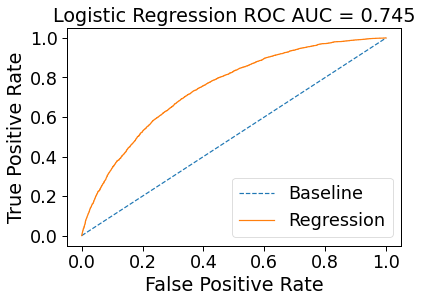

In [65]:
probs = model_3.predict_proba(X_test)
probs = probs[:,1]


fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

In [66]:
# Оценка качества:
print('accuracy_score: {}'.format(np.round(accuracy_score(y_test, y_pred), 4)))
print('f1_score: {}'.format(np.round(f1_score(y_test, y_pred), 4)))
print('recall_score: {}'.format(np.round(recall_score(y_test, y_pred), 4)))
print('MSE: {}'.format(np.round(mean_squared_error(y_test, y_pred), 4)))

accuracy_score: 0.6771
f1_score: 0.493
recall_score: 0.6913
MSE: 0.3229


<AxesSubplot:>

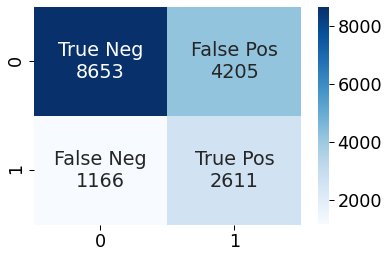

In [67]:
# Визуализация confusion matrix:
sns.set_context(context='paper', font_scale=2, rc=None)
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                confusion_matrix(y_test, y_pred).flatten()]
labels = [f'{v1}\n{v2}' for v1, v2 in
          zip(group_names, group_counts)]
labels = np.asarray(labels).reshape(2, 2)
sns.heatmap(confusion_matrix(y_test, y_pred), annot=labels, fmt='', cmap='Blues')

In [68]:
X_cat_test = OneHotEncoder(sparse = False).fit_transform(test[cat_cols].values)
X_num_test = StandardScaler().fit_transform(test[num_cols].values)
# X_test2 = np.hstack([X_num_test, test[bin_cols].values, X_cat_test])
X_test2 = np.hstack([X_num_test, test[bin_cols].values, test[poly_cols].values, X_cat_test])
y_probs = model_3.predict_proba(X_test2)[:,1]

In [69]:
y_probs = model_3.predict_proba(X_test2)[:,1]

# Применяем полученный результат на тестовых данных

In [70]:
test['default'] = y_probs

In [71]:
submission = test[['client_id','default']]
display(submission.sample(10))
display(submission.shape)

,client_id,default
93408,69798,0.204798
93394,49722,0.797896
76046,89467,0.159143
86787,88039,0.494907
96113,19008,0.388892
74911,60010,0.771147
100796,100365,0.096250
102041,105793,0.494036
107835,90336,0.406172
96708,46715,0.695912


(36349, 2)

In [72]:
submission.to_csv('submission.csv', index=False)

# Дополнительные модели

Решила немного поиграть с моделями. Но времени хватило только на RandomForest - он показал отличные результаты на тренировочных данных, но на тестовых провалился. Попозже (после сдачи проекта) попробую его докрутить (интересно же!)

In [73]:
from sklearn.ensemble import RandomForestClassifier

model_4 = RandomForestClassifier()
model_4.fit(X_train, y_train)

y_pred_rf = model_4.predict(X_test)
cf_matrix = confusion_matrix(y_test,y_pred_rf)

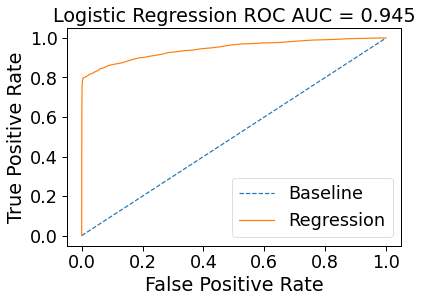

In [74]:
probs = model_4.predict_proba(X_test)
probs = probs[:,1]


fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

<AxesSubplot:>

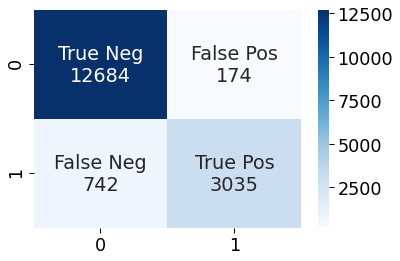

In [75]:
# Визуализация confusion matrix:
sns.set_context(context='paper', font_scale=2, rc=None)
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                confusion_matrix(y_test, y_pred_rf).flatten()]
labels = [f'{v1}\n{v2}' for v1, v2 in
          zip(group_names, group_counts)]
labels = np.asarray(labels).reshape(2, 2)
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=labels, fmt='', cmap='Blues')

Отличные результаты. Но только на тренировочном.